Generate plots for comparing and posterior analysis

It is latest results until 9 Nov, 2022


### Import some useful pkgs

In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import scipy
import torch
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr

from tqdm import trange, tqdm
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from functools import partial
from easydict import EasyDict as edict
from pathlib import Path

#### Reload my modules

In [3]:
import importlib
#import constants
#importlib.reload(constants)

from utils.misc import meg_psd2spatialfeature, get_mode, load_pkl, save_pkl
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from sgm.sgm import SGM
from spectrome import Brain, path, functions

from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

### Some functions

In [4]:
def _simulate_data(params, sgmmodel):
    """The function to simulate samples
    """
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    psd = psd[:68, :]
    spatial_fs = spatialFs.sum(axis=1)
    
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    
    res = np.concatenate([psd_fs, spatial_fs]) 
    return res

### Load real data PSD and brain

#### PSD and connectome

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


#### data for brain plots

In [6]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(DAT_ROOT/"DK68_labelorder.xlsx")
with open(DAT_ROOT/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [7]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wUreorder[orderedind]
    return wUreorder

with open(DAT_ROOT/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

#### Load parul's results

In [8]:
anl_res = pd.read_csv(DAT_ROOT/"./parul_results.csv")

### Set up Parameters

#### Set up plotting

In [9]:
metd = edict()
metd.SBI = "SBI-SGM"
metd.anl = "Ann-SGM"

plot_sets = edict()
plot_sets.col = ["dodgerblue", "coral"]
plot_sets.alpha = 0.8
plot_sets.marker = ["o", "h"]

#### Parameters

In [10]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = Path(RES_ROOT/"./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

paras.fig_dir = FIG_ROOT
paras.res_dir = RES_ROOT
paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

In [11]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [12]:
prior = sutils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))

In [13]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

### SBI way

####  Load files

In [14]:
fils = list(paras.robustParas.path.glob("robustSps_100000_sd20_*.pkl"))

tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

In [128]:
# only need to run once
for ixfil in tqdm(sorted_fils[:]):
    cur_res = load_pkl(ixfil)
    ix = tmpSortFn(ixfil)
    cur_post_psds = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        cur_sgmmodel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], FREQS, band="alpha")
        stdSp = stdz_vec(raw_sps.sum(axis=1))
        stdPsd = psd_2tr(ind_psd[:, :, iy]).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        cur_post = cur_res.posterior.set_default_x(curX)
        
        
        simulator_data_sp = partial(_simulate_data,  sgmmodel=cur_sgmmodel)
        simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, prior)
    
        print(iy)
        _, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                            num_simulations=100,
                            num_workers=50)
        cur_post_psds.append(post_psd.numpy())
        
    cur_res.cur_post_psds = cur_post_psds
    save_pkl(ixfil, cur_res, True)

  0%|                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_1.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 5 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 68 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_1.pkl


 10%|█████████████▊                                                                                                                            | 1/10 [03:19<29:55, 199.50s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_2.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_2.pkl


 20%|███████████████████████████▌                                                                                                              | 2/10 [06:35<26:18, 197.34s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_3.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_3.pkl


 30%|█████████████████████████████████████████▍                                                                                                | 3/10 [09:50<22:54, 196.34s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_4.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_4.pkl


 40%|███████████████████████████████████████████████████████▏                                                                                  | 4/10 [13:06<19:36, 196.09s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_5.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 77 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_5.pkl


 50%|█████████████████████████████████████████████████████████████████████                                                                     | 5/10 [16:23<16:22, 196.41s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_6.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_6.pkl


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 6/10 [19:38<13:03, 195.96s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_7.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_7.pkl


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7/10 [22:55<09:48, 196.33s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_8.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_8.pkl


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8/10 [26:11<06:32, 196.16s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_9.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 91 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 95 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_9.pkl


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9/10 [29:32<03:17, 197.88s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_10.pkl
0


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

2


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

3


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

4


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

5


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

6


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

7


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

8


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

9


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

10


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

11


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

12


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

13


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

14


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

15


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

16


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

17


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

18


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

19


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

20


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

21


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

22


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

23


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

24


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

25


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

26


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

27


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

28


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

29


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

30


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

31


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

32


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

33


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

34


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

35


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_10.pkl


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [32:50<00:00, 197.02s/it]


In [15]:
meg_psd_mean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_each_ROIs = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

In [16]:
corrs = []
roi_corrss = []
sgm_psd_means = []
for ixfil in sorted_fils[:]:
    cur_res = load_pkl(ixfil)
    ix = tmpSortFn(ixfil)
    est_psds = []
    for iy in range(36):
        est_psd = np.mean(cur_res.cur_post_psds[iy][:, :-68], axis=0)
        est_psd = est_psd.reshape(68, 40)
        est_psds.append(est_psd)
        
    sgm_psd_mean_new = np.array(est_psds).mean(axis=1).mean(axis=0)
    sgm_psd_means.append(sgm_psd_mean_new)
    corr = scipy.stats.pearsonr(meg_psd_mean, sgm_psd_mean_new)[0]
    corrs.append(corr)
    
    roi_corrs = []
    for iy in range(meg_psd_each_ROIs.shape[0]):
        curMEG = meg_psd_each_ROIs[iy]
        curSGM = est_psds[iy]
        roi_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    print(np.median(roi_corrs), np.mean(roi_corrs))
    roi_corrss.append(roi_corrs)
    
corrs = np.array(corrs)
roi_corrss = np.array(roi_corrss)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_1.pkl
0.8887659665931673 0.881943753962212
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_2.pkl
0.8998853082032996 0.8879211525970523
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_3.pkl
0.9015146084042021 0.888927402649267
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_4.pkl
0.8959051549364888 0.8839894285911978
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_5.pkl
0.894402049935503 0.8929196607110408
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_6.pkl
0.8899947

In [17]:
med_roi_corrs = np.median(roi_corrss, axis=1)

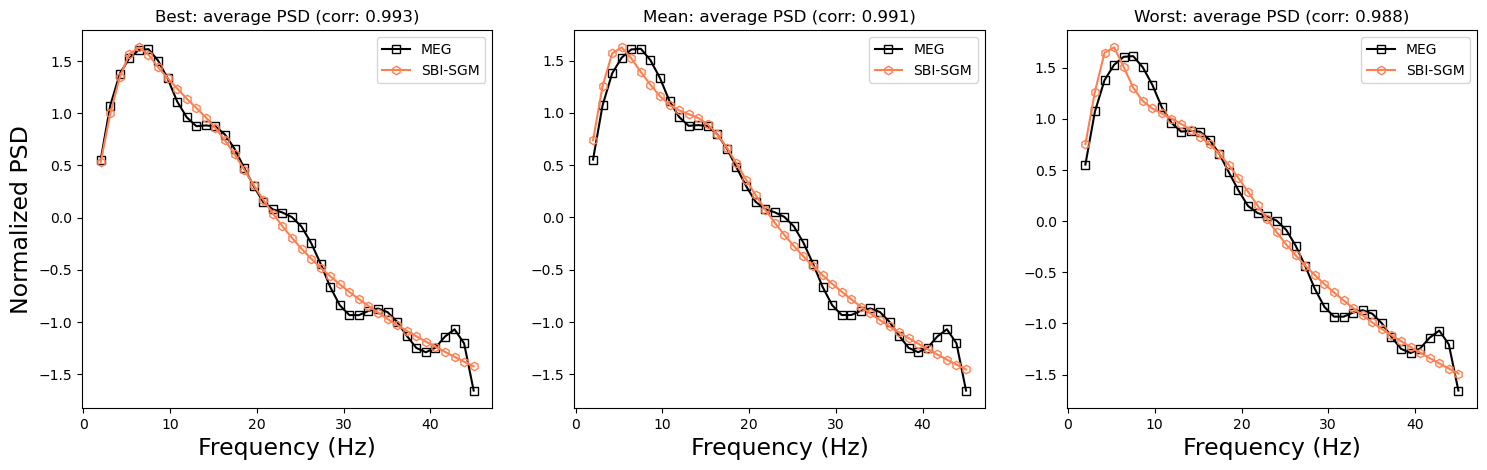

In [18]:
bestId = np.argmax(corrs)
worstId = np.argmin(corrs)
meanId = np.argmin(np.abs(corrs-np.mean(corrs)))
titles = ["Best", "Mean", "Worst"]
plt.figure(figsize=[18, 5], dpi=100)
for ix, curId in enumerate([bestId, meanId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]}: average PSD (corr: {corrs[curId]:.3f})")
    plt.plot(FREQS, stdz_vec(meg_psd_mean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
    plt.plot(FREQS, stdz_vec(sgm_psd_means[curId]), linestyle = '-',marker=plot_sets.marker[1],
         fillstyle = 'none',color = plot_sets.col[1], 
         label = metd.SBI)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    if ix == 0:
        plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(FIG_ROOT/"PSD_representative.jpg",   bbox_inches='tight')

In [20]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 58.50it/s]


In [21]:
sp_corrss = []
for ix in range(len(sorted_fils)):
    cur_res = load_pkl(sorted_fils[ix])
    est_sps = []
    for iy in range(36):
        est_sp = np.mean(cur_res.cur_post_psds[iy][:, -68:], axis=0)
        est_sps.append(est_sp)
    sp_corrs = []
    for mv, ov in zip(est_sps, MEGSPs):
        sp_corrs.append(np.dot(mv/np.linalg.norm(mv), ov))
        #sp_corrs.append(scipy.stats.pearsonr(mv, ov)[0])
    sp_corrss.append(np.array(sp_corrs))
sp_corrss = np.array(sp_corrss)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_1.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_2.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_3.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_4.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_5.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_6.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_7.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg

In [22]:
np.median(sp_corrss, axis=1)

array([0.65186317, 0.65036923, 0.65249498, 0.64790316, 0.64838822,
       0.65113547, 0.64425361, 0.64620665, 0.65019341, 0.64479683])

### Compare

Choose results from one trained model

In [23]:
# my median result
sel_res = edict()

with open(sorted_fils[meanId], "rb") as f:
    sel_res.res = pickle.load(f)
    
sel_res.PSD = sgm_psd_means[meanId]
sel_res.corr = corrs[meanId]
sel_res.PSD_corrs = roi_corrss[meanId]
sel_res.SP_corrs = sp_corrss[meanId]
sel_res.overall_psd_sps = np.array([x[:, :-68].reshape(-1, 68, 40).mean(axis=1)
                                    for x in sel_res.res.cur_post_psds]).mean(axis=0)
sel_res.overall_psd_sps = [stdz_vec(x) for x in sel_res.overall_psd_sps]

In [24]:
# taue, taui, tauC, speed, alpha, gii, gei
para_nams = ["taue", "taui", "tauC", "speed", "alpha", "gii", "gei"]
#para_nams = paras.name_order
def res_2vec(ix=0):
    vec = np.array([anl_res[nam][ix] for nam in para_nams])
    vec[:3] = vec[:3]/1000
    return vec

In [24]:
anl_sgmPSDs = []
anl_sgmSPs = []
for ix in trange(36):
    curParas = res_2vec(ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSDs.append(curPSD)
    anl_sgmSPs.append(curSPs.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:40<00:00,  1.13s/it]


#### PSD curve

In [25]:
MEGPSDMean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
anl_PSD = np.array(anl_sgmPSDs).mean(axis=1).mean(axis=0)
anl_cor = scipy.stats.pearsonr(stdz_vec(MEGPSDMean), stdz_vec(anl_PSD))[0]
lows, ups = np.quantile(sel_res.overall_psd_sps, [0.025, 0.975], axis=0)

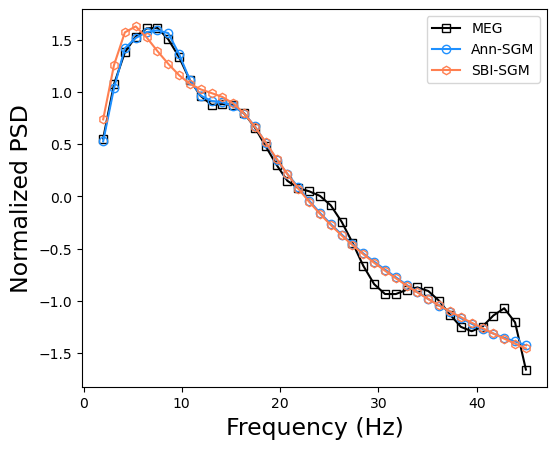

In [26]:
plt.figure(figsize=[6, 5], dpi=100)
#plt.fill_between(FREQS, lows, ups, color=plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.plot(FREQS, stdz_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(FREQS, stdz_vec(anl_PSD), linestyle = '-',marker=plot_sets.marker[0],
         fillstyle = 'none',color = plot_sets.col[0], 
         label = metd.anl)
plt.plot(FREQS, stdz_vec(sel_res.PSD), linestyle = '-',marker=plot_sets.marker[1],
         fillstyle = 'none',color = plot_sets.col[1], 
         label = metd.SBI)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

#plt.savefig(FIG_ROOT/"PSD_compare.jpg")

In [27]:
MEG_psd_each_ROIs = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
anl_PSD_corrs = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSDs[ix]
    anl_PSD_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))

In [28]:
anl_SP_corrs = []
for mv, ov in zip(anl_sgmSPs, MEGSPs):
    anl_SP_corrs.append(np.dot(mv/np.linalg.norm(mv), ov))

#### PSD and SP corrs

In [29]:
SP_both = np.array([anl_SP_corrs, sel_res.SP_corrs])
PSD_both = np.array([anl_PSD_corrs, sel_res.PSD_corrs])

In [ ]:
# not use it
for ix in range(SP_both.shape[-1]):
    plt.plot([0, 1], SP_both[:, ix], "-", color="cyan", alpha=0.8)
    
for ix in range(SP_both.shape[-1]):
    plt.plot([2, 3], PSD_both[:, ix], "-", color="cyan", alpha=0.8)
    
plt.plot([0]*36, SP_both[0, :],
         marker=plot_sets.marker[0], 
         linestyle="", 
         color=plot_sets.col[0])

plt.plot([1]*36, SP_both[1, :],
         marker=plot_sets.marker[1], 
         linestyle="", 
         color=plot_sets.col[1])

plt.plot([2]*36, PSD_both[0, :],
         marker=plot_sets.marker[0], 
         linestyle="", 
         color=plot_sets.col[0])

plt.plot([3]*36, PSD_both[1, :],
         marker=plot_sets.marker[1], 
         linestyle="", 
         color=plot_sets.col[1])

plt.xticks([0.5, 2.5], ["Spatial Corr", "PSD Corr"])

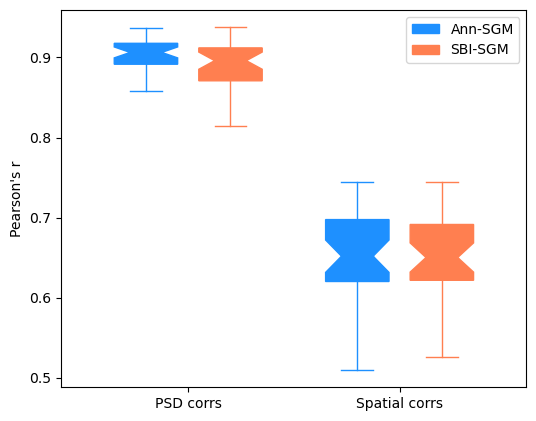

In [55]:
plt.figure(figsize=[6, 5], dpi=100)
box = plt.boxplot(PSD_both.T[:, 0], positions=[0.4],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[0])
box1 = box
    
box = plt.boxplot(PSD_both.T[:, 1], positions=[0.6],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[1])
box2 = box
    
box = plt.boxplot(SP_both.T[:, 0], positions=[.9],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[0])
    
box = plt.boxplot(SP_both.T[:, 1], positions=[1.1],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[1])
plt.xlim([0.2, 1.3])

plt.xticks([0.5, 1], ["PSD corrs", "Spatial corrs"])
plt.ylabel("Pearson's r")
plt.legend([box1["boxes"][0], box2["boxes"][0]], [metd.anl, metd.SBI])
plt.savefig(FIG_ROOT/"corr_boxplots.jpg")

#### Brain plots

In [186]:
minmax_vec5 = lambda x: 4*minmax_vec(x)+1
vec_2plot = lambda x: U2BrainVec(reorderU(minmax_vec5(x)))

anl_overall_sp =  np.mean([ix / np.linalg.norm(ix) for ix in anl_sgmSPs], axis=0)
sbi_overall_sp =  []
for cur_post_psd in sel_res.res.cur_post_psds:
    sp_vec = cur_post_psd[:, -68:].mean(axis=0)
    sp_vec = sp_vec/np.linalg.norm(sp_vec)
    sbi_overall_sp.append(sp_vec)
sbi_overall_sp = np.mean(sbi_overall_sp, axis=0)

#anl_overall_sp = np.mean(anl_sgmSPs, axis=0)
#sbi_overall_sp = np.mean(sel_res.res.sgmSPs, axis=0)
obs_overall_sp = np.mean(MEGSPRaws, axis=0)

np.savetxt(paras.res_dir/f"./sbi_sp_overall.txt", vec_2plot(sbi_overall_sp))
np.savetxt(paras.res_dir/f"./anl_sp_overall.txt", vec_2plot(anl_overall_sp))
np.savetxt(paras.res_dir/f"./obs_sp_overall.txt", vec_2plot(obs_overall_sp))
np.savetxt(paras.res_dir/f"./sbi_sp_overall_raw.txt", sbi_overall_sp)

#### Posterior sps (choose 2 subjects)

In [30]:
closest_mean_idxs = np.argsort(np.abs(sel_res.PSD_corrs - np.mean(sel_res.PSD_corrs)))[:2]
closest_mean_idxs

array([ 6, 14])

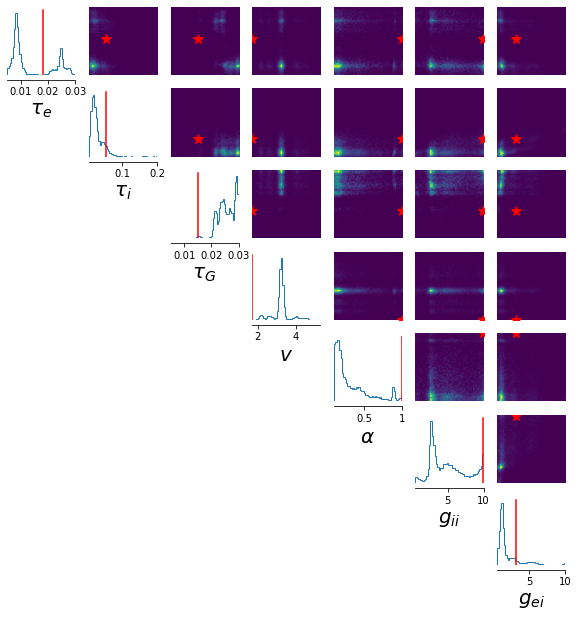

In [33]:
#cur_ind_psd = np.argsort(sel_res.PSD_corrs)[17]
cur_ind_psd = closest_mean_idxs[0]
# taue, taui, tauC, speed, alpha, gii, gei
plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(sel_res.res.postSpss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="*", markersize=10),
                      limits=plotLimits, 
                      #upper="scatter",
                      #scatter_offdiag=dict(marker=".", s=5),
                      labels=paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(paras.fig_dir/f"postsps_ex{cur_ind_psd}.jpg",  bbox_inches='tight')

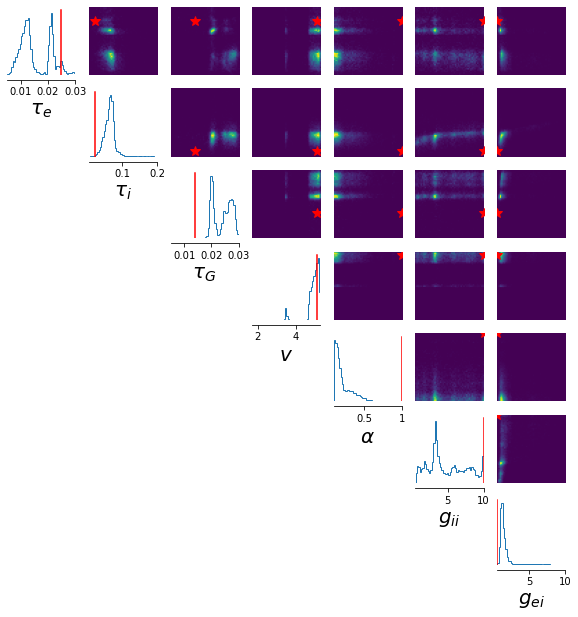

In [34]:
#cur_ind_psd = np.argsort(sel_res.PSD_corrs)[18]
cur_ind_psd = closest_mean_idxs[1]
# taue, taui, tauC, speed, alpha, gii, gei
plt.rc('axes', labelsize=20) 
t = analysis.pairplot(sel_res.res.postSpss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="*", markersize=10),
                      limits=plotLimits, 
                      #upper="scatter",
                      #scatter_offdiag=dict(marker=".", s=5),
                      labels=paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(paras.fig_dir/f"postsps_ex{cur_ind_psd}.jpg", bbox_inches='tight')

### Diagnosis

#### Predictive checks

The dim of output is too high to check

In [217]:
cur_ind_psd = closest_mean_idxs[1]
#cur_ind_psd = np.argsort(sel_res.PSD_corrs)[18]
post_psds = []
post_sps = []
for ix in trange(0, 10000, 10):
    cur_paras = sel_res.res.postSpss[cur_ind_psd][ix, :]
    curC = ind_conn[:, :, cur_ind_psd]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(cur_paras)
    curPSD = curPSD[:68, :]
    
    simuout_PSD = psd_2tr(curPSD)
    simuout_SP = curSPs.sum(axis=1)
    post_psds.append(simuout_PSD)
    post_sps.append(simuout_SP)
    
with open(paras.res_dir/f"post_PSDxSP_{cur_ind_psd}.pkl", "wb") as f:
    pickle.dump([post_psds, post_sps], f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:58<00:00,  1.26s/it]


In [268]:
cur_ind_psd

6

In [95]:
cur_ind_psd = closest_mean_idxs[1]
#cur_ind_psd = np.argsort(sel_res.PSD_corrs)[17]
with open(paras.res_dir/f"post_PSDxSP_{cur_ind_psd}.pkl", "rb") as f:
    post_psds, post_sps = pickle.load(f)

In [96]:
sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, cur_ind_psd], FREQS, band="alpha")
obs_meg_sp = raw_sps.sum(axis=1)
obs_meg_sp = stdz_vec(raw_sps.sum(axis=1))
obs_meg_psd = stdz_vec(psd_2tr(ind_psd[:, :, cur_ind_psd]).mean(axis=0))

In [97]:
post_psds_m = np.array([stdz_vec((post_psds[ix]+np.random.randn(68, 40)*0.0).mean(axis=0)) 
                        for ix in range(len(post_psds))])
post_sps1 = np.array([stdz_vec(post_sps[ix])+np.random.randn(68)*0.0 
                      for ix in range(len(post_sps))])

In [98]:
# umap
post_psds_flat = np.array([ix.flatten() for ix in post_psds])
#post_psds_flat = np.array([ix.mean(axis=0)+np.random.randn(40)*0 for ix in post_psds])
reducer = umap.UMAP(n_components=5, random_state=2022)
reducer.fit(post_psds_flat)

red_post_psds = reducer.transform(post_psds_flat)
red_meg_psd =  reducer.transform(psd_2tr(ind_psd[:, :, cur_ind_psd]).flatten().reshape(1, -1))
#red_meg_psd =  reducer.transform(psd_2tr(ind_psd[:, :, cur_ind_psd]).mean(axis=0).reshape(1, -1))

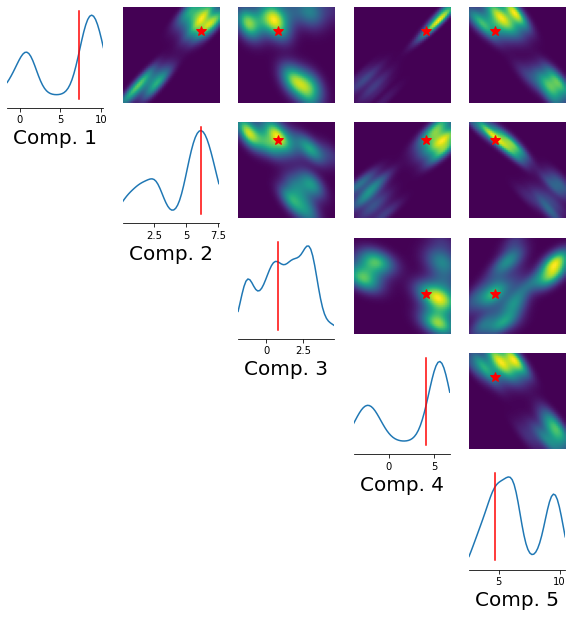

In [99]:
plt.rc('axes', labelsize=20) 
_ = analysis.pairplot(red_post_psds, 
                  points=red_meg_psd,
                  points_colors="red",
                  points_offdiag=dict(marker="*", markersize=10),
                  upper="kde",
                  diag="kde",
                  labels=[f"Comp. {ix+1}" for ix in range(5)],
                  figsize=(10,10), dpi=100)
plt.rc('axes', labelsize=10) 
plt.savefig(paras.fig_dir/f"umap_ppc_s_ex{cur_ind_psd}.jpg", bbox_inches='tight')

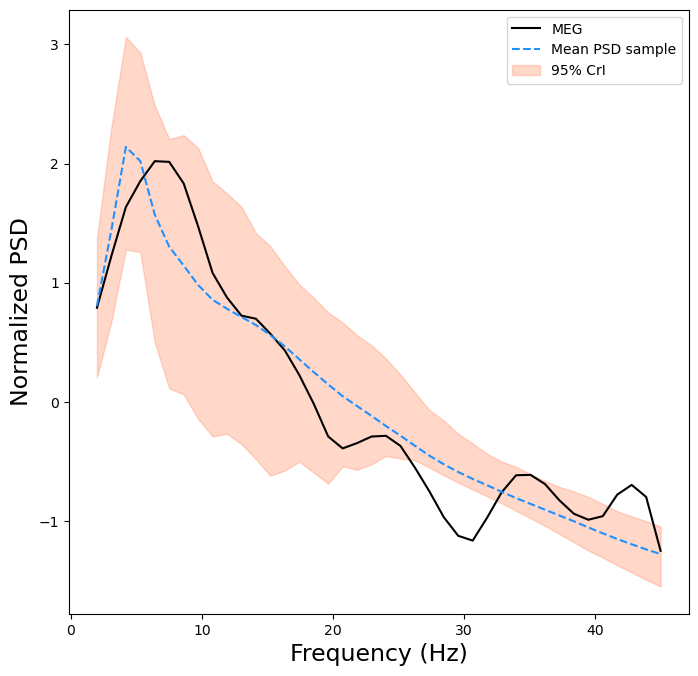

In [40]:
# PSD plot
plt.figure(figsize=[8, 8], dpi=100)
lows, ups = np.quantile(post_psds_m, [0.025, 0.975], axis=0)
plt.fill_between(FREQS, lows, ups, color=plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.plot(FREQS, obs_meg_psd, color='black', label="MEG")
plt.plot(FREQS, np.mean(post_psds_m, axis=0), color=plot_sets.col[0], linestyle="--", 
         label="Mean PSD sample")
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/f"newpost_PSDs_ex{cur_ind_psd}.jpg",  bbox_inches='tight')

In [124]:
minmax_vec5 = lambda x: 4*minmax_vec(x)+1
vec_2plot = lambda x: U2BrainVec(reorderU(minmax_vec5(x)))
# get results for plotting
sbi_out_sp = sel_res.res.sgmSPs[cur_ind_psd]
anl_out_sp = anl_sgmSPs[cur_ind_psd]
post_mean_sp = np.array(post_sps).mean(axis=0)
obs_meg_sp = raw_sps.sum(axis=1)

np.savetxt(paras.res_dir/f"./sbi_sp_{cur_ind_psd}.txt", vec_2plot(sbi_out_sp))
np.savetxt(paras.res_dir/f"./anl_sp_{cur_ind_psd}.txt", vec_2plot(anl_out_sp))
np.savetxt(paras.res_dir/f"./post_sp_{cur_ind_psd}.txt", vec_2plot(post_mean_sp))
np.savetxt(paras.res_dir/f"./obs_sp_{cur_ind_psd}.txt", vec_2plot(obs_meg_sp))

#### CrI for all data

In [234]:
# save thte psd for all data (only need once)
cur_ind_psd = closest_mean_idxs[1]
for cur_ind_psd in trange(36):
    if cur_ind_psd in closest_mean_idxs:
        continue
    post_psds = []
    post_sps = []
    for ix in range(0, 10000, 10):
        cur_paras = sel_res.res.postSpss[cur_ind_psd][ix, :]
        curC = ind_conn[:, :, cur_ind_psd]
        curBrain = Brain.Brain()
        curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
        curPSD, curSPs = curSgmModel.run_local_coupling_forward(cur_paras)
        curPSD = curPSD[:68, :]
        
        simuout_PSD = psd_2tr(curPSD)
        simuout_SP = curSPs.sum(axis=1)
        post_psds.append(simuout_PSD)
        post_sps.append(simuout_SP)
        
    with open(paras.res_dir/f"post_PSDxSP_{cur_ind_psd}.pkl", "wb") as f:
        pickle.dump([post_psds, post_sps], f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [11:32:35<00:00, 1154.32s/it]


In [315]:
all_fils = list(paras.res_dir.glob("post_PSDxSP*"))
sorted_fn = lambda x: int(x.stem.split("_")[-1])
all_fils = sorted(all_fils, key=sorted_fn)

In [316]:
all_post_psds_mean = []
for fil in all_fils:
    cur_post_psds, _ = load_pkl(fil)
    cur_post_psds_mean = [cur_post_psds[ix].mean(axis=0) 
                          for ix in range(len(cur_post_psds))]
    all_post_psds_mean.append(cur_post_psds_mean)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_0.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_1.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_2.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_3.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_4.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_5.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_6.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_7.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_8.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_PSDxSP_9.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/post_P

In [317]:
all_post_psds_mean = np.array(all_post_psds_mean)
overall_psd_sps = all_post_psds_mean.mean(axis=0)
MEGPSDMean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)

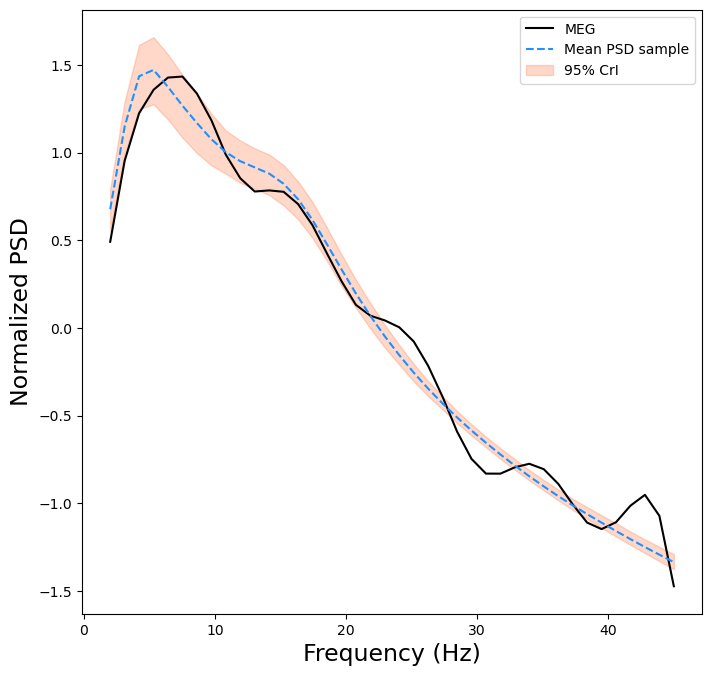

In [318]:
# PSD all plot
plt.figure(figsize=[8, 8], dpi=100)
lows, ups = np.quantile(overall_psd_sps, [0.025, 0.975], axis=0)
plt.fill_between(FREQS, lows, ups, color=plot_sets.col[1], alpha=0.3, label="95% CrI")
plt.plot(FREQS, MEGPSDMean, color='black', label="MEG")
plt.plot(FREQS, np.mean(overall_psd_sps, axis=0), color=plot_sets.col[0], linestyle="--", 
         label="Mean PSD sample")
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/f"newpost_PSDs_all.jpg",  bbox_inches='tight')

#### Histogram of all data

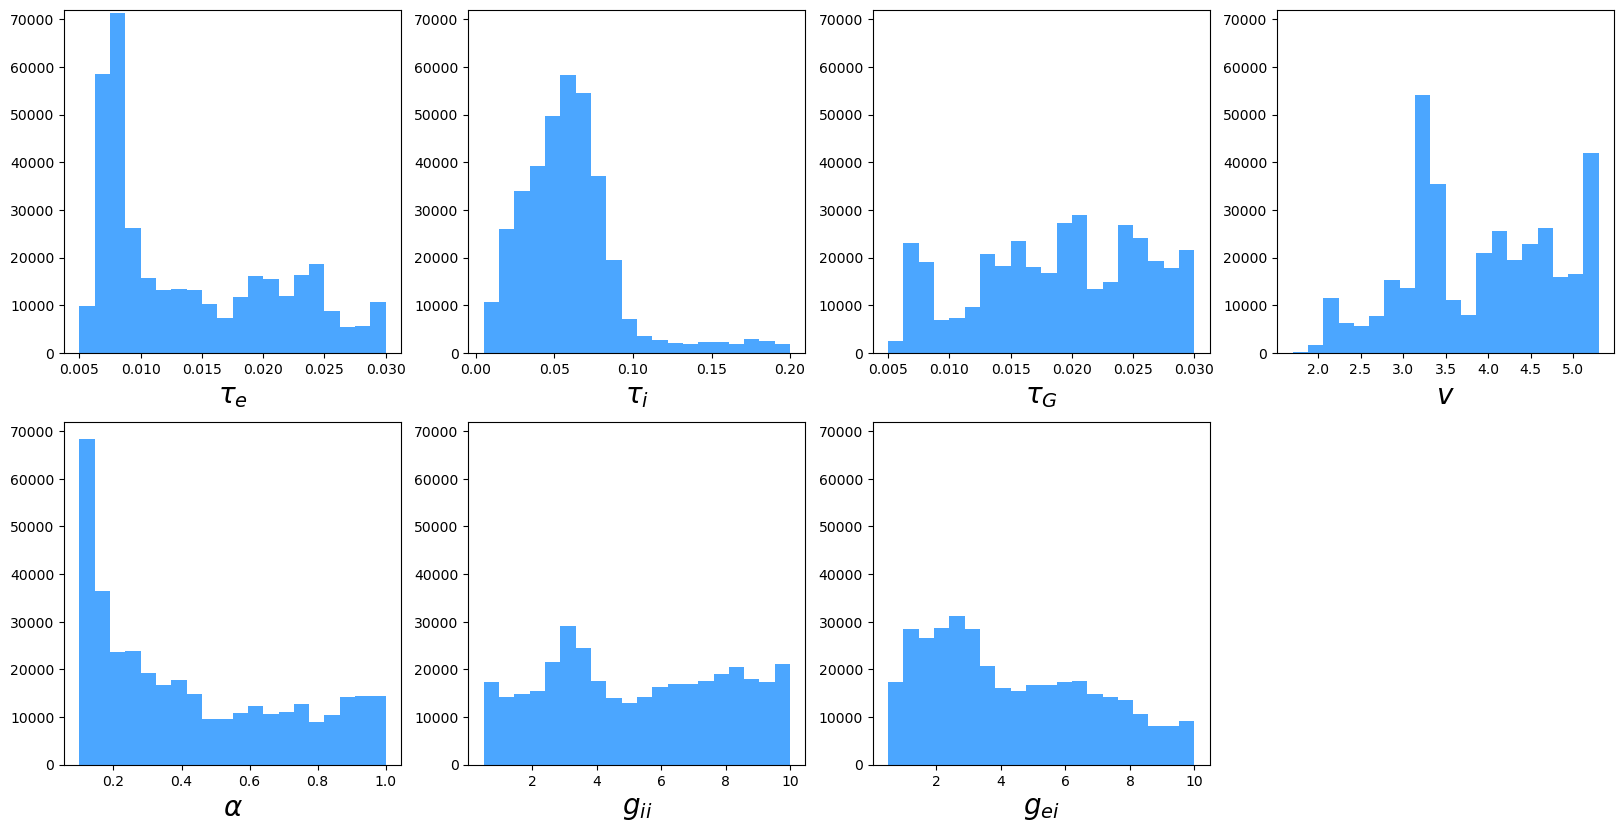

In [30]:
post_spss_pool = np.array([ix.numpy() for ix in sel_res.res.postSpss]).reshape(-1, 7)

ix = 0
#plt.figure(figsize=[20, 10])
plt.figure(figsize=[20, 10], dpi=100)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.hist(post_spss_pool[:, ix], bins=20, density=False, 
             alpha=0.8, color=plot_sets.col[0])
    #sns.kdeplot(post_spss_pool[:, ix],
    #         color=plot_sets.col[1])
    adj_fct = np.diff(plotLimits[ix])*np.array([-0.05, 0.05])
    plt.xlim(plotLimits[ix]+adj_fct)
    plt.xlabel(paras.name_order_latex[ix], fontsize=20)
    plt.ylim([0, 72000])
    plt.ylabel("")
    
plt.savefig(paras.fig_dir/f"newpost_histpara_all.jpg",  bbox_inches='tight')

#### Conditional distribution

In [103]:
# obtain conditional corr mat for all subjects
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
            
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS, band="alpha")
    stdSp = stdz_vec(raw_sps.mean(axis=1))
    stdPsd = psd_2tr(ind_psd[:, :, ix]).flatten()
    curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
    cur_sps = sel_res.res.postSpss[ix][::50, :]
    cur_posterior = sel_res.res.posterior.set_default_x(curX)
    
    cur_cond_corr_mat = analysis.conditional_corrcoeff(density=cur_posterior, 
                                                       condition=cur_sps,
                                                       limits=torch.Tensor(plotLimits))
    with open(paras.res_dir/f"cond_corr_{ix}.pkl", "wb") as f:
        pickle.dump(cur_cond_corr_mat, f)

  0%|                                                                                                                                                   | 0/36 [00:00<?, ?it/s]/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(
/opt/conda/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwar

In [168]:
corr_fils = list(paras.res_dir.glob("cond_corr_*.pkl"))
sorted_corr_fils = sorted(corr_fils, key=lambda x: int(x.stem.split("_")[-1]))
corr_mats = []
for ix_fil in sorted_corr_fils:
    with open(ix_fil, "rb") as f:
        cur_mat = pickle.load(f)
    corr_mats.append(cur_mat.numpy())

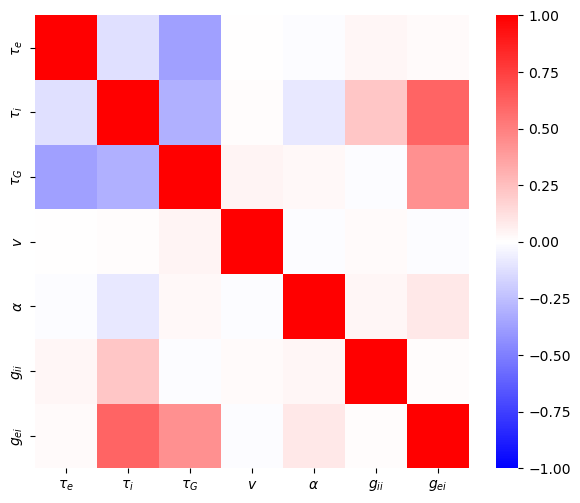

In [169]:
plt.figure(figsize=[7, 6], dpi=100)
sns.heatmap(np.mean(corr_mats, axis=0), vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, paras.name_order_latex)
plt.yticks(np.arange(7)+0.5, paras.name_order_latex);
plt.savefig(paras.fig_dir/f"cond_corr_all_mean.jpg",  bbox_inches='tight');

### Others

In [76]:
### Save the point estimate from one trained model
pt_SBI_SGM = []
for postSps in sel_res.res.postSpss:
    pt_SBI_SGM.append(np.median(postSps.numpy(), axis=0))
paras.name_order
pt_SBI_SGM = np.array(pt_SBI_SGM)
pt_SBI_SGM = {paras.name_order[ix]:pt_SBI_SGM[:, ix] for ix in range(7)}

In [82]:
out = pd.DataFrame(pt_SBI_SGM)
out.to_csv(paras.res_dir/"SBISGM_point_estimate.csv")